##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

from IPython.display import Image

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/word2vec">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank"
    href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/word2vec.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/word2vec.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/word2vec.ipynb">
    <img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

# Word2Vec

Word2Vec is not a singular algorithm, rather, it is a family of model architectures and optimizations that can be
used to learn word embeddings from large datasets. Embeddings learned through Word2Vec have proven to be
successful on a variety of downstream natural language processing tasks.

Note: This tutorial is based on
[Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/pdf/1301.3781.pdf) and
[Distributed Representations of Words and Phrases and their Compositionality](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf).
It is not an exact implementation of the papers. Rather, it is intended to illustrate the key ideas.

These papers proposed two methods for learning representations of words: 

*   **Continuous Bag-of-Words Model** which predicts the middle word based on surrounding context words. The context
consists of a few words before and after the current (middle) word. This architecture is called a bag-of-words model
as the order of words in the context is not important.
*   **Continuous Skip-gram Model** which predict words within a certain range before and after the current word in
the same sentence. A worked example of this is given below.


You'll use the skip-gram approach in this tutorial. First, you'll explore skip-grams and other concepts using a
single sentence for illustration. Next, you'll train your own Word2Vec model on a small dataset. This tutorial
also contains code to export the trained embeddings and visualize them in the
[TensorFlow Embedding Projector](http://projector.tensorflow.org/).


## Skip-gram and Negative Sampling 

While a bag-of-words model predicts a word given the neighboring context, a skip-gram model predicts the context
(or neighbors) of a word, given the word itself. The model is trained on skip-grams, which are n-grams that
allow tokens to be skipped (see the diagram below for an example). The context of a word can be represented
through a set of skip-gram pairs of `(target_word, context_word)` where `context_word` appears in the neighboring
context of `target_word`.

Consider the following sentence of 8 words.
> The wide road shimmered in the hot sun. 

The context words for each of the 8 words of this sentence are defined by a window size. The window size determines
the span of words on either side of a `target_word` that can be considered `context word`. Take a look at this
table of skip-grams for target words based on different window sizes.

Note: For this tutorial, a window size of *n* implies n words on each side with a total window span of 2*n+1 words
across a word.

In [2]:
path=%pwd

path=path+'/images/word2vec_skipgram.png'

path

'/home/bhaskar/Documents/PycharmProjects/handson-ml2/text/images/word2vec_skipgram.png'

/bin/bash: -c: line 0: syntax error near unexpected token `./images/word2vec_skipgram.png'
/bin/bash: -c: line 0: `[word2vec_skipgrams](./images/word2vec_skipgram.png)'


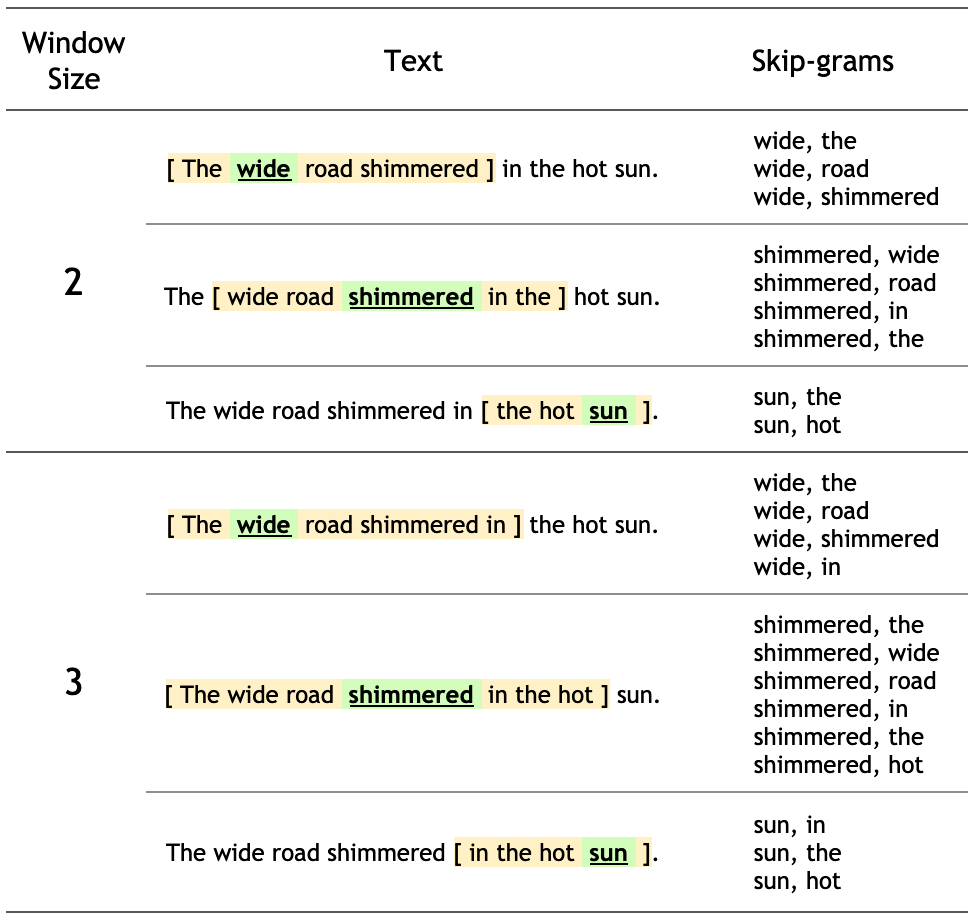

In [3]:
![word2vec_skipgrams](./images/word2vec_skipgram.png)

Image(filename='./images/word2vec_skipgram.png')

The training objective of the skip-gram model is to maximize the probability of predicting context words given
the target word. For a sequence of words *w<sub>1</sub>, w<sub>2</sub>, ... w<sub>T</sub>*, the objective can be
written as the average log probability

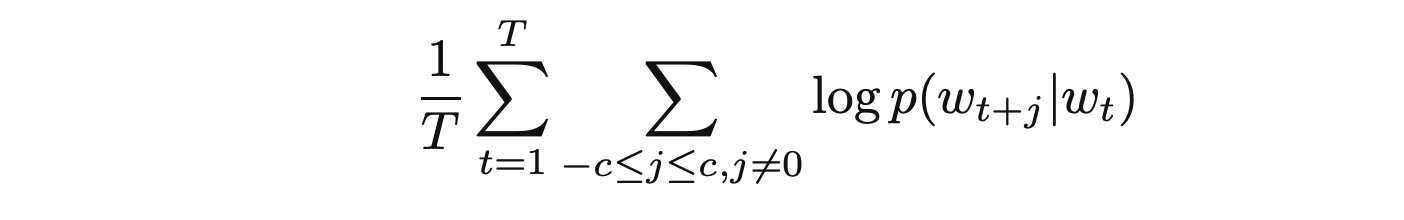

In [4]:
Image(filename='./images/word2vec_skipgram_objective.png')
# ![word2vec_skipgram_objective](images/word2vec_skipgram_objective.png)

where `c` is the size of the training context. The basic skip-gram formulation defines this probability using
the softmax function.

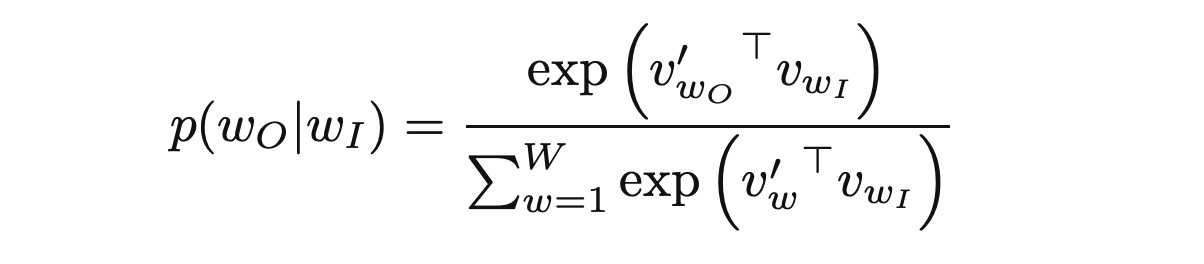

In [5]:
Image(filename='./images/word2vec_full_softmax.png')
# ![word2vec_full_softmax](images/word2vec_full_softmax.png)

where *v* and *v<sup>'<sup>* are target and context vector representations of words and *W* is vocabulary size. 

Computing the denominator of this formulation involves performing a full softmax over the entire vocabulary words
which is often large (10<sup>5</sup>-10<sup>7</sup>) terms.

The [Noise Contrastive Estimation](https://www.tensorflow.org/api_docs/python/tf/nn/nce_loss) loss function is an
efficient approximation for a full softmax. With an objective to learn word embeddings instead of modelling the
word distribution, NCE loss can be
[simplified](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) to use negative sampling.

The simplified negative sampling objective for a target word is to distinguish  the context word from *num_ns*
negative samples drawn from noise distribution *P<sub>n</sub>(w)* of words. More precisely, an efficient
approximation of full softmax over the vocabulary is, for a skip-gram pair, to pose the loss for a target word
as a classification problem between the context word and *num_ns* negative samples.

A negative sample is defined as a (target_word, context_word) pair such that the context_word does not appear in
the `window_size` neighborhood of the target_word. For the example sentence, these are few potential negative
samples (when `window_size` is 2).

```
(hot, shimmered)
(wide, hot)
(wide, sun)
```

In the next section, you'll generate skip-grams and negative samples for a single sentence. You'll also learn about
subsampling techniques and train a classification model for positive and negative training examples later in the
tutorial.

## Setup

In [6]:
!pip install -q tqdm

In [7]:
import io
import itertools
import numpy as np
import os
import re
import string
import tensorflow as tf
tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)

import tqdm

from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Activation, Dense, Dot, Embedding, Flatten, GlobalAveragePooling1D, Reshape
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

%load_ext tensorboard

In [8]:
SEED = 42 
AUTOTUNE = tf.data.experimental.AUTOTUNE

### Vectorize an example sentence

Consider the following sentence:    
`The wide road shimmered in the hot sun.`

Tokenize the sentence:

In [9]:
sentence = "The wide road shimmered in the hot sun"
tokens = list(sentence.lower().split())
print(len(tokens))

8


Create a vocabulary to save mappings from tokens to integer indices.

In [10]:
vocab, index = {}, 1 # start indexing from 1
vocab['<pad>'] = 0 # add a padding token

for token in tokens:
  if token not in vocab: 
    vocab[token] = index
    index += 1

vocab_size = len(vocab)
print(vocab)

{'<pad>': 0, 'the': 1, 'wide': 2, 'road': 3, 'shimmered': 4, 'in': 5, 'hot': 6, 'sun': 7}


Create an inverse vocabulary to save mappings from integer indices to tokens.

In [11]:
inverse_vocab = {index: token for token, index in vocab.items()}
print(inverse_vocab)

{0: '<pad>', 1: 'the', 2: 'wide', 3: 'road', 4: 'shimmered', 5: 'in', 6: 'hot', 7: 'sun'}


Vectorize your sentence.


In [12]:
example_sequence = [vocab[word] for word in tokens]
print(example_sequence)

[1, 2, 3, 4, 5, 1, 6, 7]


### Generate skip-grams from one sentence

The `tf.keras.preprocessing.sequence` module provides useful functions that simplify data preparation for Word2Vec.
You can use the `tf.keras.preprocessing.sequence.skipgrams` to generate skip-gram pairs from the `example_sequence`
with a given `window_size` from tokens in the range `[0, vocab_size)`.

Note: `negative_samples` is set to `0` here as batching negative samples generated by this function requires a bit
of code. You will use another function to perform negative sampling in the next section.


In [13]:
window_size = 2
positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
      example_sequence, 
      vocabulary_size=vocab_size,
      window_size=window_size,
      negative_samples=0)

print(len(positive_skip_grams))

26


Take a look at few positive skip-grams.

In [14]:
for target, context in positive_skip_grams[:5]:
  print(f"({target}, {context}): ({inverse_vocab[target]}, {inverse_vocab[context]})")

(7, 1): (sun, the)
(6, 7): (hot, sun)
(2, 1): (wide, the)
(3, 2): (road, wide)
(1, 2): (the, wide)


### Negative sampling for one skip-gram 

The `skipgrams` function returns all positive skip-gram pairs by sliding over a given window span. To produce
additional skip-gram pairs that would serve as negative samples for training, you need to sample random words
from the vocabulary. Use the `tf.random.log_uniform_candidate_sampler` function to sample `num_ns` number of
negative samples for a given target word in a window. You can call the funtion on one skip-grams's target word
and pass the context word as true class to exclude it from being sampled.


Key point: *num_ns* (number of negative samples per positive context word) between [5, 20] is
[shown to work](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)
best for smaller datasets, while *num_ns* between [2,5] suffices for larger datasets.

In [15]:
# Get target and context words for one positive skip-gram.
target_word, context_word = positive_skip_grams[0]

# Set the number of negative samples per positive context. 
num_ns = 4

context_class = tf.reshape(tf.constant(context_word, dtype="int64"), (1, 1))
negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
    true_classes=context_class, # class that should be sampled as 'positive'
    num_true=1, # each positive skip-gram has 1 positive context class
    num_sampled=num_ns, # number of negative context words to sample
    unique=True, # all the negative samples should be unique
    range_max=vocab_size, # pick index of the samples from [0, vocab_size]
    seed=SEED, # seed for reproducibility
    name="negative_sampling" # name of this operation
)
print(negative_sampling_candidates)
print([inverse_vocab[index.numpy()] for index in negative_sampling_candidates])

tf.Tensor([2 1 4 3], shape=(4,), dtype=int64)
['wide', 'the', 'shimmered', 'road']


### Construct one training example

For a given positive `(target_word, context_word)` skip-gram, you now also have `num_ns` negative sampled context
words that do not appear in the window size neighborhood of `target_word`. Batch the `1` positive `context_word`
and `num_ns` negative context words into one tensor. This produces a set of positive skip-grams (labelled as `1`)
and negative samples (labelled as `0`) for each target word.

In [16]:
# Add a dimension so you can use concatenation (on the next step).
negative_sampling_candidates = tf.expand_dims(negative_sampling_candidates, 1)

# Concat positive context word with negative sampled words.
context = tf.concat([context_class, negative_sampling_candidates], 0)

# Label first context word as 1 (positive) followed by num_ns 0s (negative).
label = tf.constant([1] + [0]*num_ns, dtype="int64") 

# Reshape target to shape (1,) and context and label to (num_ns+1,).
target = tf.squeeze(target_word)
context = tf.squeeze(context)
label =  tf.squeeze(label)

Take a look at the context and the corresponding labels for the target word from the skip-gram example above. 

In [17]:
print(f"target_index    : {target}")
print(f"target_word     : {inverse_vocab[target_word]}")
print(f"context_indices : {context}")
print(f"context_words   : {[inverse_vocab[c.numpy()] for c in context]}")
print(f"label           : {label}")

target_index    : 7
target_word     : sun
context_indices : [1 2 1 4 3]
context_words   : ['the', 'wide', 'the', 'shimmered', 'road']
label           : [1 0 0 0 0]


A tuple of `(target, context, label)` tensors constitutes one training example for training your skip-gram
negative sampling Word2Vec model. Notice that the target is of shape `(1,)` while the context and label are
of shape `(1+num_ns,)`

In [18]:
print(f"target  :", target)
print(f"context :", context )
print(f"label   :", label )

target  : tf.Tensor(7, shape=(), dtype=int32)
context : tf.Tensor([1 2 1 4 3], shape=(5,), dtype=int64)
label   : tf.Tensor([1 0 0 0 0], shape=(5,), dtype=int64)


### Summary

This picture summarizes the procedure of generating training example from a sentence. 


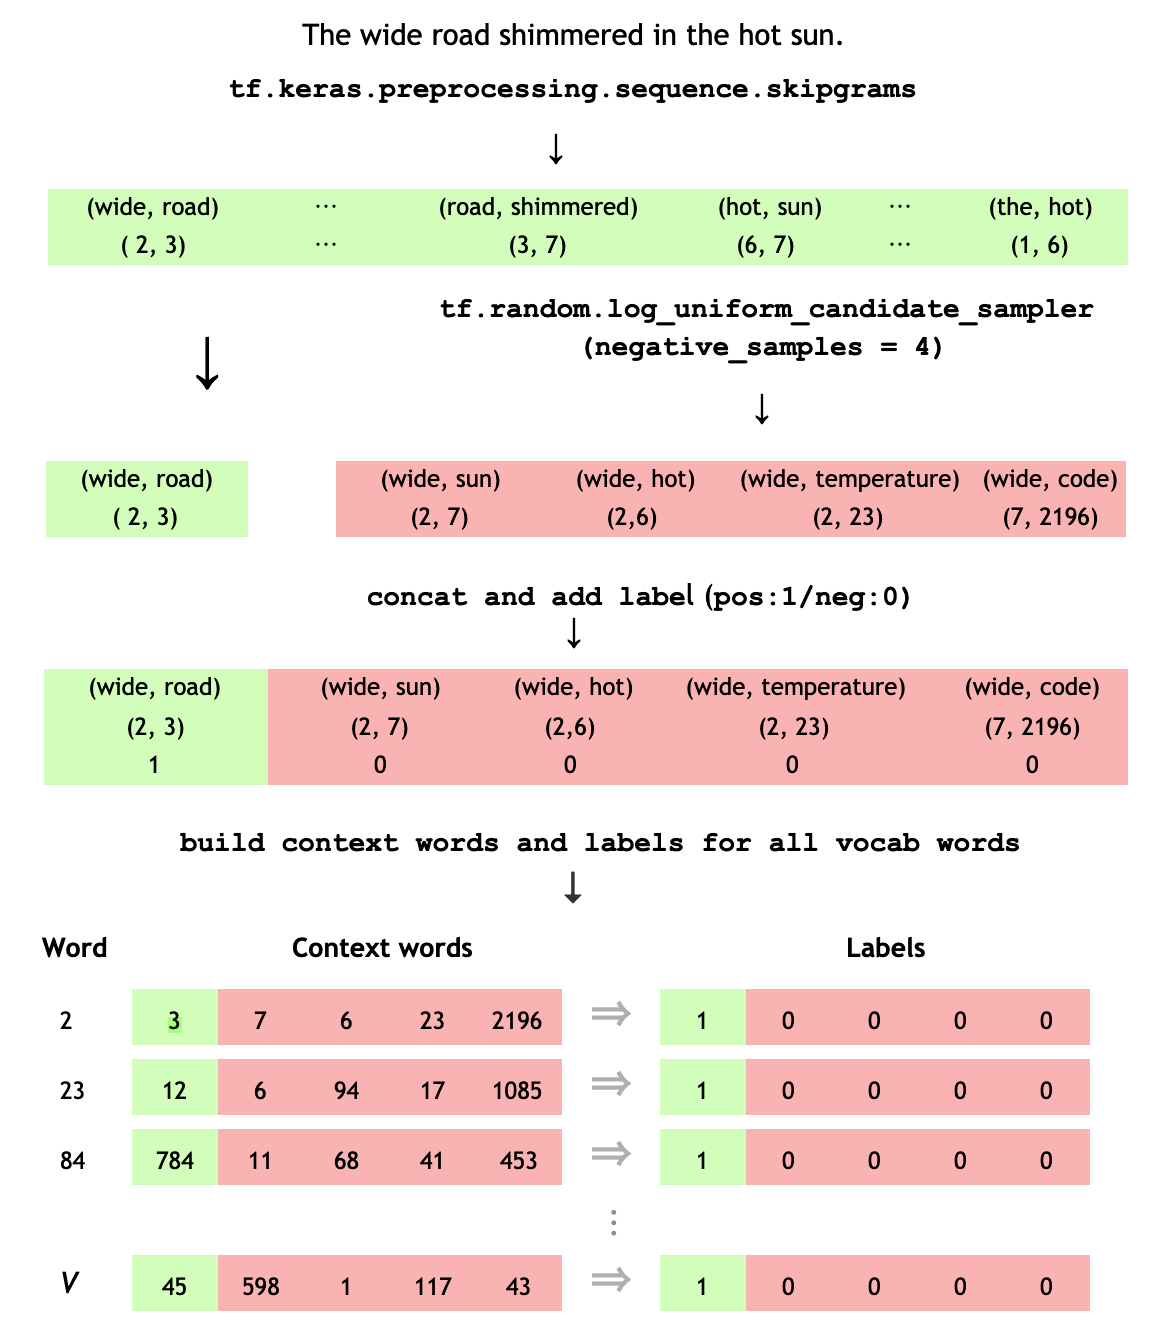

In [19]:
Image('./images/word2vec_negative_sampling.png')
# ![word2vec_negative_sampling](images/word2vec_negative_sampling.png)

## Compile all steps into one function


### Skip-gram Sampling table 

A large dataset means larger vocabulary with higher number of more frequent words such as stopwords. Training
examples obtained from sampling commonly occuring words (such as `the`, `is`, `on`) don't add much useful information
for the model to learn from.
[Mikolov et al.](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)
 suggest subsampling of frequent words as a helpful practice to improve embedding quality.

The `tf.keras.preprocessing.sequence.skipgrams` function accepts a sampling table argument to encode probabilities
of sampling any token. You can use the `tf.keras.preprocessing.sequence.make_sampling_table` to  generate a
word-frequency rank based probabilistic sampling table and pass it to `skipgrams` function. Take a look at the
sampling probabilities for a `vocab_size` of 10.

In [20]:
sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(size=10)
print(sampling_table)

[0.00315225 0.00315225 0.00547597 0.00741556 0.00912817 0.01068435
 0.01212381 0.01347162 0.01474487 0.0159558 ]


`sampling_table[i]` denotes the probability of sampling the i-th a most common word in a dataset. The function assumes a
[Zipf's distribution](https://en.wikipedia.org/wiki/Zipf%27s_law) of the word frequencies for sampling.

Key point: The `tf.random.log_uniform_candidate_sampler` already assumes that the vocabulary frequency follows a
log-uniform (Zipf's) distribution. Using these distribution weighted sampling also helps approximate the
Noise Contrastive Estimation (NCE) loss with simpler loss functions for training a negative sampling objective.

### Generate training data

Compile all the steps described above into a function that can be called on a list of vectorized sentences
obtained from any text dataset. Notice that the sampling table is built before sampling skip-gram word pairs. You
will use this function in the latter sections.

In [21]:
# Generates skip-gram pairs with negative sampling for a list of sequences
# (int-encoded sentences) based on window size, number of negative samples
# and vocabulary size.
def generate_training_data(sequences, window_size, num_ns, vocab_size, seed):
  # Elements of each training example are appended to these lists.
  targets, contexts, labels = [], [], []

  # Build the sampling table for vocab_size tokens.
  sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)

  # Iterate over all sequences (sentences) in dataset.
  for sequence in tqdm.tqdm(sequences):

    # Generate positive skip-gram pairs for a sequence (sentence).
    positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
          sequence, 
          vocabulary_size=vocab_size,
          sampling_table=sampling_table,
          window_size=window_size,
          negative_samples=0)
    
    # Iterate over each positive skip-gram pair to produce training examples 
    # with positive context word and negative samples.
    for target_word, context_word in positive_skip_grams:
      context_class = tf.expand_dims(
          tf.constant([context_word], dtype="int64"), 1)
      negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
          true_classes=context_class,
          num_true=1, 
          num_sampled=num_ns, 
          unique=True, 
          range_max=vocab_size, 
          seed=SEED, 
          name="negative_sampling")
      
      # Build context and label vectors (for one target word)
      negative_sampling_candidates = tf.expand_dims(
          negative_sampling_candidates, 1)

      context = tf.concat([context_class, negative_sampling_candidates], 0)
      label = tf.constant([1] + [0]*num_ns, dtype="int64")

      # Append each element from the training example to global lists.
      targets.append(target_word)
      contexts.append(context)
      labels.append(label)

  return targets, contexts, labels

## Prepare training data for Word2Vec

With an understanding of how to work with one sentence for a skip-gram negative sampling based Word2Vec model, you can proceed to generate training examples from a larger list of sentences!

### Download text corpus


You will use a text file of Shakespeare's writing for this tutorial. Change the following line to run this code on your own data.

In [22]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

Read text from the file and take a look at the first few lines. 

In [23]:
with open(path_to_file) as f: 
  lines = f.read().splitlines()
for line in lines[:20]:
  print(line)

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.


Use the non empty lines to construct a `tf.data.TextLineDataset` object for next steps.

In [24]:
text_ds = tf.data.TextLineDataset(path_to_file).filter(lambda x: tf.cast(tf.strings.length(x), bool))

### Vectorize sentences from the corpus

You can use the `TextVectorization` layer to vectorize sentences from the corpus. Learn more about using this layer in this [Text Classification](https://www.tensorflow.org/tutorials/keras/text_classification) tutorial. Notice from the first few sentences above that the text needs to be in one case and punctuation needs to be removed. To do this, define a `custom_standardization function` that can be used in the TextVectorization layer.

In [25]:
# We create a custom standardization function to lowercase the text and 
# remove punctuation.
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  return tf.strings.regex_replace(lowercase,
                                  '[%s]' % re.escape(string.punctuation), '')

# Define the vocabulary size and number of words in a sequence.
vocab_size = 4096
sequence_length = 10

# Use the text vectorization layer to normalize, split, and map strings to
# integers. Set output_sequence_length length to pad all samples to same length.
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

Call `adapt` on the text dataset to create vocabulary.


In [26]:
vectorize_layer.adapt(text_ds.batch(1024))

Once the state of the layer has been adapted to represent the text corpus, the vocabulary can be accessed with `get_vocabulary()`. This function returns a list of all vocabulary tokens sorted (descending) by their frequency. 

In [27]:
# Save the created vocabulary for reference.
inverse_vocab = vectorize_layer.get_vocabulary()
print(inverse_vocab[:20])

['', '[UNK]', 'the', 'and', 'to', 'i', 'of', 'you', 'my', 'a', 'that', 'in', 'is', 'not', 'for', 'with', 'me', 'it', 'be', 'your']


The vectorize_layer can now be used to generate vectors for each element in the `text_ds`.

In [28]:
def vectorize_text(text):
  text = tf.expand_dims(text, -1)
  return tf.squeeze(vectorize_layer(text))

# Vectorize the data in text_ds.
text_vector_ds = text_ds.batch(1024).prefetch(AUTOTUNE).map(vectorize_layer).unbatch()

### Obtain sequences from the dataset

You now have a `tf.data.Dataset` of integer encoded sentences. To prepare the dataset for training a Word2Vec model, flatten the dataset into a list of sentence vector sequences. This step is required as you would iterate over each sentence in the dataset to produce positive and negative examples. 

Note: Since the `generate_training_data()` defined earlier uses non-TF python/numpy functions, you could also use a `tf.py_function` or `tf.numpy_function` with `tf.data.Dataset.map()`.

In [29]:
sequences = list(text_vector_ds.as_numpy_iterator())
print(len(sequences))

32777


Take a look at few examples from `sequences`.


In [30]:
for seq in sequences[:5]:
  print(f"{seq} => {[inverse_vocab[i] for i in seq]}")

[ 89 270   0   0   0   0   0   0   0   0] => ['first', 'citizen', '', '', '', '', '', '', '', '']
[138  36 982 144 673 125  16 106   0   0] => ['before', 'we', 'proceed', 'any', 'further', 'hear', 'me', 'speak', '', '']
[34  0  0  0  0  0  0  0  0  0] => ['all', '', '', '', '', '', '', '', '', '']
[106 106   0   0   0   0   0   0   0   0] => ['speak', 'speak', '', '', '', '', '', '', '', '']
[ 89 270   0   0   0   0   0   0   0   0] => ['first', 'citizen', '', '', '', '', '', '', '', '']


### Generate training examples from sequences

`sequences` is now a list of int encoded sentences. Just call the `generate_training_data()` function defined earlier to generate training examples for the Word2Vec model. To recap, the function iterates over each word from each sequence to collect positive and negative context words. Length of target, contexts and labels should be same, representing the total number of training examples.

In [31]:
targets, contexts, labels = generate_training_data(
    sequences=sequences, 
    window_size=2, 
    num_ns=4, 
    vocab_size=vocab_size, 
    seed=SEED)
print(len(targets), len(contexts), len(labels))

100%|██████████| 32777/32777 [00:15<00:00, 2065.51it/s]


64452 64452 64452


### Configure the dataset for performance

To perform efficient batching for the potentially large number of training examples, use the `tf.data.Dataset` API. After this step, you would have a `tf.data.Dataset` object of `(target_word, context_word), (label)` elements to train your Word2Vec model!

In [32]:
BATCH_SIZE = 1024
BUFFER_SIZE = 10000
dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print(dataset)

<BatchDataset shapes: (((1024,), (1024, 5, 1)), (1024, 5)), types: ((tf.int32, tf.int64), tf.int64)>


Add `cache()` and `prefetch()` to improve performance.

In [33]:
dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
print(dataset)

<PrefetchDataset shapes: (((1024,), (1024, 5, 1)), (1024, 5)), types: ((tf.int32, tf.int64), tf.int64)>


## Model and Training

The Word2Vec model can be implemented as a classifier to distinguish between true context words from skip-grams and false context words obtained through negative sampling. You can perform a dot product between the embeddings of target and context words to obtain predictions for labels and compute loss against true labels in the dataset.

### Subclassed Word2Vec Model

Use the [Keras Subclassing API](https://www.tensorflow.org/guide/keras/custom_layers_and_models) to define your Word2Vec model with the following layers:


* `target_embedding`: A `tf.keras.layers.Embedding` layer which looks up the embedding of a word when it appears as a target word. The number of parameters in this layer are `(vocab_size * embedding_dim)`.
* `context_embedding`: Another `tf.keras.layers.Embedding` layer which looks up the embedding of a word when it appears as a context word. The number of parameters in this layer are the same as those in `target_embedding`, i.e. `(vocab_size * embedding_dim)`.
* `dots`: A `tf.keras.layers.Dot` layer that computes the dot product of target and context embeddings from a training pair.
* `flatten`: A `tf.keras.layers.Flatten` layer to flatten the results of `dots` layer into logits.

With the sublassed model, you can define the `call()` function that accepts `(target, context)` pairs which can then be passed into their corresponding embedding layer. Reshape the `context_embedding` to perform a dot product with `target_embedding` and return the flattened result.

Key point: The `target_embedding` and `context_embedding` layers can be shared as well. You could also use a concatenation of both embeddings as the final Word2Vec embedding.

In [34]:
class Word2Vec(Model):
  def __init__(self, vocab_size, embedding_dim):
    super(Word2Vec, self).__init__()
    self.target_embedding = Embedding(vocab_size, 
                                      embedding_dim,
                                      input_length=1,
                                      name="w2v_embedding", )
    self.context_embedding = Embedding(vocab_size, 
                                       embedding_dim, 
                                       input_length=num_ns+1)
    self.dots = Dot(axes=(3,2))
    self.flatten = Flatten()

  def call(self, pair):
    target, context = pair
    we = self.target_embedding(target)
    ce = self.context_embedding(context)
    dots = self.dots([ce, we])
    return self.flatten(dots)

### Define loss function and compile model


For simplicity, you can use `tf.keras.losses.CategoricalCrossEntropy` as an alternative to the negative sampling loss. If you would like to write your own custom loss function, you can also do so as follows:

``` python
def custom_loss(x_logit, y_true):
      return tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=y_true)
```

It's time to build your model! Instantiate your Word2Vec class with an embedding dimension of 128 (you could experiment with different values). Compile the model with the `tf.keras.optimizers.Adam` optimizer. 

In [35]:
embedding_dim = 128
word2vec = Word2Vec(vocab_size, embedding_dim)
word2vec.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Also define a callback to log training statistics for tensorboard.

In [36]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

Train the model with `dataset` prepared above for some number of epochs.

In [37]:
word2vec.fit(dataset, epochs=20, callbacks=[tensorboard_callback])

Epoch 1/20
 1/62 [..............................] - ETA: 0s - loss: 1.6099 - accuracy: 0.1875WARNING:tensorflow:From /home/bhaskar/anaconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
62/62 [==============================] - 1s 16ms/step - loss: 1.6083 - accuracy: 0.2327

Tensorboard now shows the Word2Vec model's accuracy and loss.

```python
%tensorboard --logdir logs
```

In [38]:
%tensorboard --logdir logs

Launching TensorBoard...

![word2vec_tensorboard](images/word2vec_tensorboard.png)

## Embedding lookup and analysis

Obtain the weights from the model using `get_layer()` and `get_weights()`. The `get_vocabulary()` function provides the vocabulary to build a metadata file with one token per line. 

In [39]:
weights = word2vec.get_layer('w2v_embedding').get_weights()[0]
vocab = vectorize_layer.get_vocabulary()

Create and save the vectors and metadata file. 

In [40]:
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
  if  index == 0: continue # skip 0, it's padding.
  vec = weights[index] 
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

Download the `vectors.tsv` and `metadata.tsv` to analyze the obtained embeddings in the [Embedding Projector](https://projector.tensorflow.org/).

In [41]:
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception as e:
  pass

## Next steps


This tutorial has shown you how to implement a skip-gram Word2Vec model with negative sampling from scratch and visualize the obtained word embeddings.

* To learn more about word vectors and their mathematical representations, refer to these [notes](https://web.stanford.edu/class/cs224n/readings/cs224n-2019-notes01-wordvecs1.pdf).

* To learn more about advanced text processing, read the [Transformer model for language understanding](https://www.tensorflow.org/tutorials/text/transformer) tutorial.

* If you’re interested in pre-trained embedding models, you may also be interested in [Exploring the TF-Hub CORD-19 Swivel Embeddings](https://www.tensorflow.org/hub/tutorials/cord_19_embeddings_keras), or the [Multilingual Universal Sentence Encoder](https://www.tensorflow.org/hub/tutorials/cross_lingual_similarity_with_tf_hub_multilingual_universal_encoder)

* You may also like to train the model on a new dataset (there are many available in [TensorFlow Datasets](https://www.tensorflow.org/datasets)).
